In [6]:
#Set up the environment
library(tidyverse)
library(reshape2)
library(data.table)

In [28]:
#Load in the ancestry information for all of the cell lines
setwd('../data')
ancestry.calls = read.table("ccle_snp6_ancestry_calls.txt", sep = "\t", header = T) %>%
rename("sample" = 1, "afr" = 2, "amr" = 3, "eas" = 4, "eur" = 5, "sas" = 6) %>%
mutate("ancestry_call" = ifelse(afr >= 0.8, "afr",
                               ifelse(amr >= 0.8, "amr",
                                     ifelse(eas >= 0.8, "eas",
                                           ifelse(eur >= 0.8, "eur",
                                                 ifelse(sas >= 0.8, "sas", "admixed"))))))


ancestry.calls$sample %>% length
ancestry.calls$ancestry_call %>% length()

[1] 994

[1] 994

In [34]:
#Load in the sample info
setwd("../data")
sample.info = read.table("22q1_sample_info.csv", sep = ",", header = T, check.names = FALSE, fill = TRUE, row.names = NULL, quote="\"")
msi.status = read.table("23q4_omics_signatures.csv", sep = ",", header = T, check.names = FALSE, fill = TRUE) %>%
rename("sample" = 1)

In [35]:
#Load in the data and construct a single data frame
setwd("../data")
sample.names = read.table("directory_names.txt", sep = "\t") %>%
rename("sample" = 1) %>%
mutate(sample = gsub("..*ACH", "ACH", sample)) %>%
mutate(sample = gsub("/", "", sample)) %>%
pull(sample)

num.shared = read.table("num_shared.txt", sep = "\t") %>% pull(1) #Number of shared variants
num.snp6 = read.table("num_snp6_only.txt", sep = "\t") %>% pull(1) #Number of variants in only snp6
num.wgs = read.table("num_wgs_only.txt", sep = "\t") %>% pull(1) #Number of variants in only wgs


#Bind everything into a single data frame
intersecting.variants.df = cbind(sample.names, num.shared, num.snp6, num.wgs) %>%
data.frame() %>%
rename("sample" = 1, "shared" = 2, "snp6_only" = 3, "wgs_only" = 4) %>%
mutate("ancestry" = plyr::mapvalues(from = ancestry.calls$sample, to = ancestry.calls$ancestry_call, sample, warn_missing = FALSE)) %>%
mutate(shared = as.numeric(shared)) %>%
mutate(snp6_only = as.numeric(snp6_only)) %>%
mutate(wgs_only = as.numeric(wgs_only)) %>%
mutate("fraction_shared" = shared/(shared + snp6_only + wgs_only)) %>%
mutate("fraction_snp6_only" = snp6_only/(shared + snp6_only + wgs_only)) %>%
mutate("fraction_wgs_only" = wgs_only/(shared + snp6_only + wgs_only)) %>%
arrange(ancestry) %>%
mutate(ancestry = factor(ancestry, levels = c("afr", "amr", "eas", "eur", "sas", "admixed"))) %>%
mutate("lineage" = plyr::mapvalues(from = sample.info$DepMap_ID, to = sample.info$lineage, sample, warn_missing = FALSE)) %>%
mutate("msi" = plyr::mapvalues(from = msi.status$sample, to = msi.status$MSIScore, sample, warn_missing = FALSE)) %>%
mutate(msi = as.numeric(msi)) %>%
mutate("msi_status" = ifelse(msi > 10, "high", "low"))

intersecting.variants.df %>% head()

,sample,shared,snp6_only,wgs_only,ancestry,fraction_shared,fraction_snp6_only,fraction_wgs_only,lineage,msi,msi_status
,<chr>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<chr>
1,ACH-000277,3398245,90131,1232858,admixed,0.7197790,0.019090560,0.2611305,breast,3.14,low
2,ACH-000375,3742031,40384,1488481,admixed,0.7099421,0.007661695,0.2823962,soft_tissue,2.19,low
3,ACH-000427,3519689,95784,1604386,admixed,0.6742881,0.018349921,0.3073619,gastric,3.34,low
4,ACH-000568,3303082,62468,1234229,admixed,0.7180958,0.013580652,0.2683235,breast,2.25,low
5,ACH-000668,3278794,137157,1978702,admixed,0.6077859,0.025424620,0.3667895,breast,3.34,low
6,ACH-000679,3181506,119996,1367969,admixed,0.6813418,0.025697986,0.2929602,esophagus,2.04,low


Warning message:
“The melt generic in data.table has been passed a data.frame and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is superseded and is no longer actively developed, and this redirection is now deprecated. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace, i.e. reshape2::melt(.). In the next version, this warning will become an error.”
Warning message:
“The melt generic in data.table has been passed a data.frame and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is superseded and is no longer actively developed, and this redirection is now deprecated. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace, i.e. reshape2::melt(.). In the next version, this warning will become an error.”


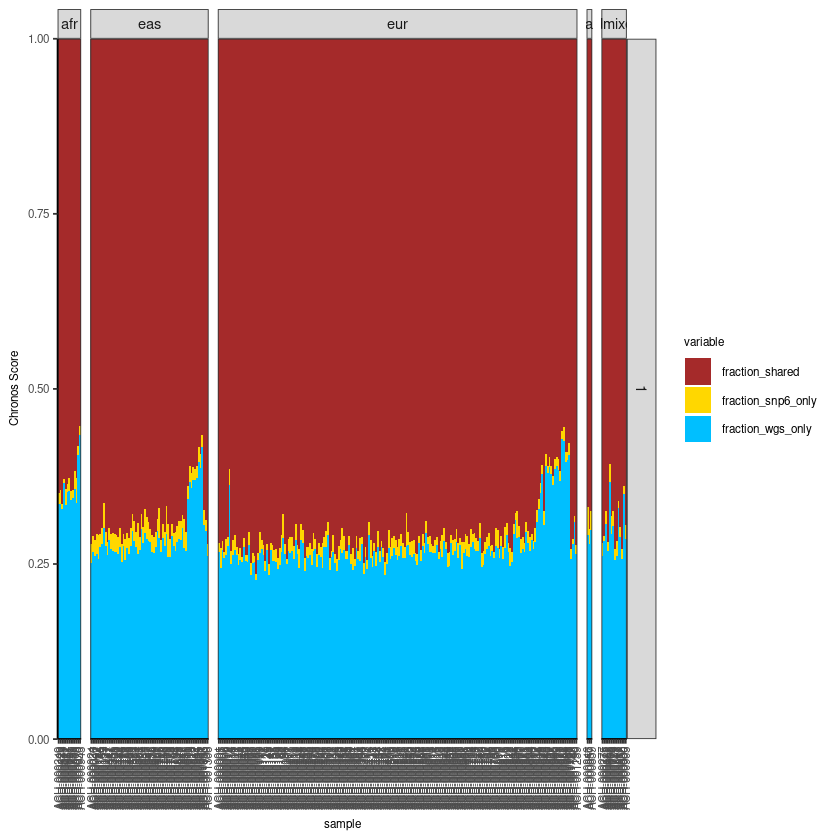

Warning message:
“The melt generic in data.table has been passed a data.frame and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is superseded and is no longer actively developed, and this redirection is now deprecated. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace, i.e. reshape2::melt(.). In the next version, this warning will become an error.”


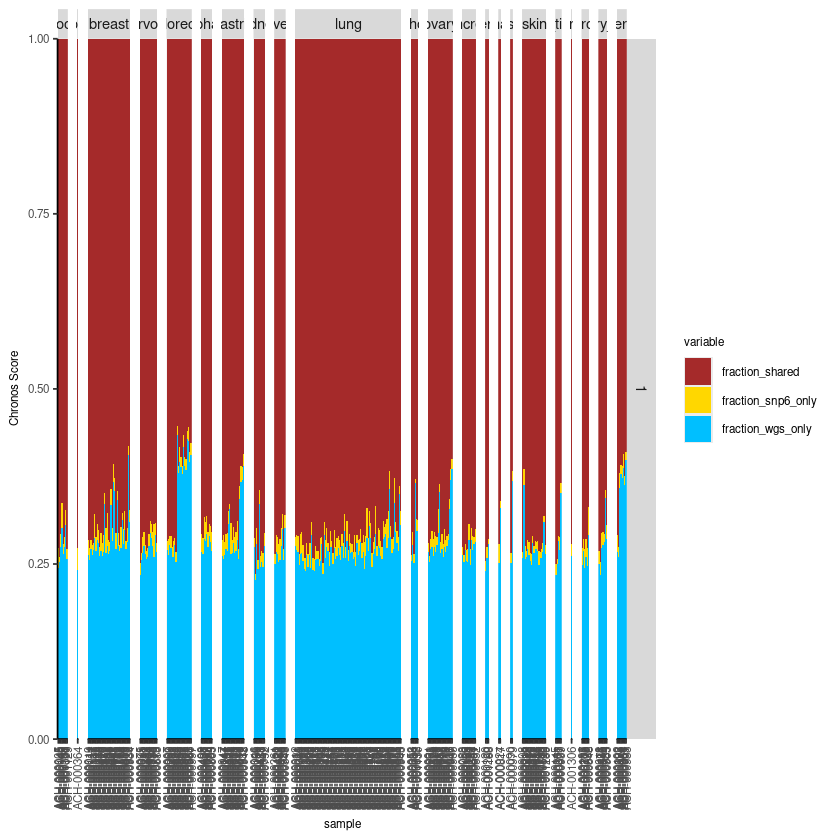

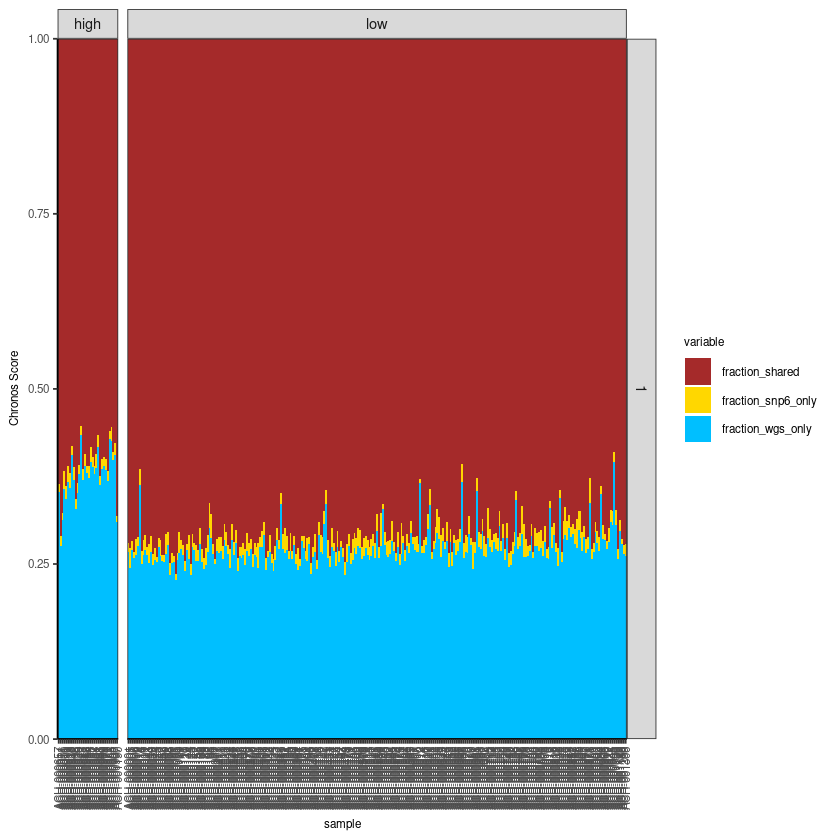

In [37]:
###plot the plots
#For ancestry
intersecting.variants.df %>%
filter(fraction_shared > 0) %>%
melt(id = c("sample", "ancestry", "lineage", "msi_status")) %>%
filter(variable %in% c("fraction_shared", "fraction_snp6_only", "fraction_wgs_only")) %>%
ggplot(aes(x = sample, y = value, fill = variable)) +
geom_bar(stat = "identity", width = 1) +
facet_grid(1 ~ ancestry, scales = "free", space='free') +
scale_fill_manual(values = c("brown", "gold", "deepskyblue")) +
theme_bw() +

theme(
panel.grid.major = element_blank(),
panel.grid.minor = element_blank(), 
axis.line = element_line(color = "black")
) +

theme(
axis.title.x = element_text(size = 7),
axis.title.y = element_text(size = 7)
) +

theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) +

theme(
axis.text=element_text(size = 7),
axis.title=element_text(size = 7)
) +

theme(
legend.title = element_text(size = 7),
legend.text = element_text(size = 7)
) +

scale_y_continuous(expand = c(0, 0)) +

ylab("Chronos Score")

#Export it to the google bucket
setwd('../output')
ggsave("supplemental_figure_5_6_a.pdf", width = 9, height = 5)



#For lineage
intersecting.variants.df %>%
filter(fraction_shared > 0) %>%
melt(id = c("sample", "ancestry", "lineage", "msi_status")) %>%
filter(variable %in% c("fraction_shared", "fraction_snp6_only", "fraction_wgs_only")) %>%
ggplot(aes(x = sample, y = value, fill = variable)) +
geom_bar(stat = "identity", width = 1) +
facet_grid(1 ~ lineage, scales = "free", space = 'free') +
scale_fill_manual(values = c("brown", "gold", "deepskyblue")) +

theme(
panel.grid.major = element_blank(),
panel.grid.minor = element_blank(), 
axis.line = element_line(color = "black")
) +

theme(
axis.title.x = element_text(size = 7),
axis.title.y = element_text(size = 7)
) +

theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) +

theme(
axis.text=element_text(size = 7),
axis.title=element_text(size = 7)
) +

theme(
legend.title = element_text(size = 7),
legend.text = element_text(size = 7)
) +

scale_y_continuous(expand = c(0, 0)) +

ylab("Chronos Score")

#Export it to the google bucket
setwd('../output')
ggsave("supplemental_figure_5_6_b.pdf", width = 9, height = 5)



#For msi status
intersecting.variants.df %>%
filter(fraction_shared > 0) %>%
melt(id = c("sample", "ancestry", "lineage", "msi_status")) %>%
filter(variable %in% c("fraction_shared", "fraction_snp6_only", "fraction_wgs_only")) %>%
ggplot(aes(x = sample, y = value, fill = variable)) +
geom_bar(stat = "identity", width = 1) +
facet_grid(1 ~ msi_status, scales = "free", space='free') +
scale_fill_manual(values = c("brown", "gold", "deepskyblue")) +
theme_bw() +

theme(
panel.grid.major = element_blank(),
panel.grid.minor = element_blank(), 
axis.line = element_line(color = "black")
) +

theme(
axis.title.x = element_text(size = 7),
axis.title.y = element_text(size = 7)
) +

theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) +

theme(
axis.text=element_text(size = 7),
axis.title=element_text(size = 7)
) +

theme(
legend.title = element_text(size = 7),
legend.text = element_text(size = 7)
) +

scale_y_continuous(expand = c(0, 0)) +

ylab("Chronos Score")

#Export it to the google bucket
setwd('../output')
ggsave("supplemental_figure_5_6_c.pdf", width = 9, height = 5)


In [36]:
#Write the input dataframe
df_for_plotting = intersecting.variants.df %>%
filter(fraction_shared > 0) %>%
melt(id = c("sample", "ancestry", "lineage", "msi_status")) %>%
filter(variable %in% c("fraction_shared", "fraction_snp6_only", "fraction_wgs_only"))

setwd("../output")
write.table(df_for_plotting, "supplemental_figure_5_6_df.txt", sep = "\t", col.names = TRUE, row.names = FALSE, quote = FALSE)

Warning message:
“The melt generic in data.table has been passed a data.frame and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is superseded and is no longer actively developed, and this redirection is now deprecated. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace, i.e. reshape2::melt(.). In the next version, this warning will become an error.”
